In [92]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [93]:
import numpy as np
import pandas as pd

In [94]:
import datetime as dt

In [95]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [96]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [97]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [98]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [99]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [100]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [101]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [102]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [103]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [104]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [105]:
 # Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [111]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

latest_date

('2017-08-23')

In [113]:
# Calculate the date 1 year ago from the last data point in the database
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year

datetime.date(2016, 8, 23)

In [114]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date, Measurement.prcp]

twelve_months = session.query(*sel).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

prcp_data_df = pd.DataFrame(twelve_months)
prcp_data_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


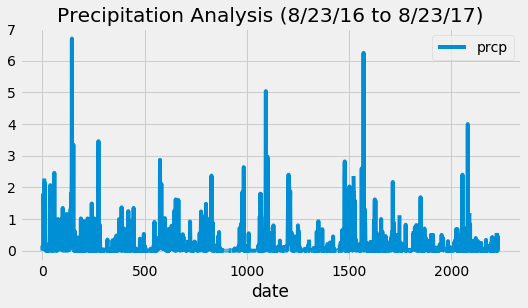

In [118]:
ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/23/16 to 8/23/17)")
ax.set_ylabel
ax.set_xlabel('date')
plt.show()

In [120]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [134]:
# Design a query to show how many stations are available in this dataset?
location_count = session.query(Measurement).group_by(Measurement.station).count()
print(f"Total number of stations: {str(location_count)}")

Total number of stations: 9


In [125]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by('count DESC').all()

active_df = pd.DataFrame(active_stations)
active_df.head()


,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [126]:
 # Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

In [141]:
most_active = active_df["station"][0]
most_active

'USC00519281'

In [143]:
tempcalc = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*tempcalc).filter(Measurement.station==most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [145]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs = session.query(Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == most_active).\
    order_by(Measurement.tobs).all()

most_obs_df = pd.DataFrame(most_obs)
most_obs_df.head()

,tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


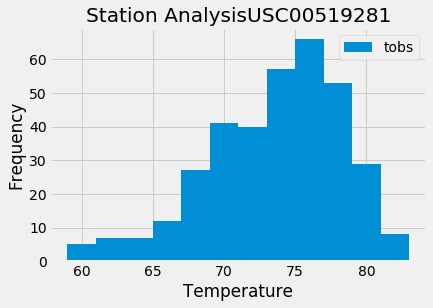

In [149]:
plt.hist(most_obs_df['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis" +""+ most_active)
plt.legend(["tobs"])
plt.show()

In [166]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
trip_temp1 = calc_temps('2017-01-01', '2017-08-23')
trip_temp1

[(58.0, 74.14387974230493, 87.0)]

In [157]:
 # Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
 trip_temp = calc_temps('2016-01-01', '2016-08-23')
trip_temp

[(56.0, 73.49224544841537, 83.0)]

In [158]:
trip_df = pd.DataFrame(trip_temp, columns=['Min Temp', 'Avg Temp', 'Max Temp'])

trip_df

,Min Temp,Avg Temp,Max Temp
0,56.0,73.492245,83.0


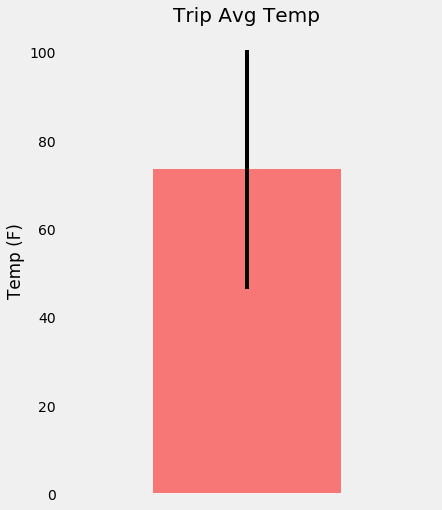

In [161]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='red')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("/Users/vanjoisscott/Downloads/TripTemp.png")
plt.show()

In [182]:
Rainfall = session.query(Measurement.station, func.sum(Measurement.prcp).label('Rainfall')).\
            group_by(Measurement.station).\
            order_by('Rainfall DESC').all()

Rainfall_df = pd.DataFrame(Rainfall)
Rainfall_df

,station,Rainfall
0,USC00516128,1068.09
1,USC00519281,588.64
2,USC00513117,382.62
3,USC00519523,295.68
4,USC00514830,234.49
5,USC00519397,131.62
6,USC00511918,92.68
7,USC00518838,70.87
8,USC00517948,43.44


In [210]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


info = [Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]

Results = Session.query(*info)\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date>=trip_temp1).filter(Measurement.date<=trip_temp).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()



SyntaxError: invalid syntax (<ipython-input-210-d6ad2cd202f6>, line 8)